In [1]:
%matplotlib inline
import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.wrapped_xgboost import xgboost_classifier
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel
from utils.data_munge import remove_single_value_columns

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'
nan_fill_value = -2.


In [3]:
bin_num = 1 ## number of bins to separate data by start_time
tmp_train, tmp_test, bins, bin_names = bosch_functions.create_grouped_index_df(bin_num)

data loading takes  57.7  seconds.


In [119]:
def creat_non_selected_window_num(bin_num, select_bin = '0'):
    none_selected_window_num = [np.NaN]
    for i in range(bin_num):
        if str(i) != select_bin:
            none_selected_window_num.append(str(i))
    return none_selected_window_num
    
none_selected_window_num = creat_non_selected_window_num(bin_num, '0')
skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()

print tmp_train.shape, tmp_test.shape, len(skipped_train_row_num), len(skipped_test_row_num)

(1183747, 3) (1183748, 3) 1048954 1049267


In [120]:
nrows = 50000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file), skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)
train_cat = pd.read_csv(join(data_path, train_cat_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)

all_labels = pd.read_csv(join(data_path, train_num_file), index_col='Id', usecols=['Response', 'Id'])

print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 50.0 seconds


In [122]:
start_time = time.time()
nrows = 50000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),  index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file), index_col='Id', nrows = nrows)
#train_cat = pd.read_csv(join(data_path, train_cat_file),  index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

In [187]:
print train_num.shape, train_dat.shape

(50000, 969) (50000, 1156)


In [177]:
#combined_train = pd.merge(train_num, train_dat, how='left', left_index=True, right_index=True)
#print combined_train.shape

In [342]:
num_station_dict = {}
dat_station_dict = {}

for col in train_dat.columns:
    col_list = col.split('_')
    station_name = '_'.join(col_list[:2])
    if station_name in dat_station_dict:
        dat_station_dict[station_name].append(col)
    else:
        dat_station_dict[station_name] = [col]
        
        
for col in train_num.columns:
    if col == 'Response':
        continue
    col_list = col.split('_')
    station_name = '_'.join(col_list[:2])
    if station_name in num_station_dict:
        num_station_dict[station_name].append(col)
    else:
        num_station_dict[station_name] = [col]


In [361]:
tmp_train_dat = train_dat.copy()
tmp_train_num = train_num.copy()

In [362]:
def getRelativeTimeColumns(series):
    '''
    normalize the time features by
    the start_time, the first none-NaN
    value
    '''
    if series[0] == np.NaN:
        start_time = series.dropna().index[0]
    else:
        start_time = series[0]
    new_series = series - start_time
    return new_series
   

tmp_train_dat_norm = tmp_train_dat.apply(getRelativeTimeColumns, axis=1)

In [363]:
## unique features: mean, max, min, #NaN, #unique_value, 
def get_Date_StationFeatures(series):
    series_value = {}
    for station_name, col_names in dat_station_dict.items():
        station_value = series[col_names]
        station_name = '{}_time'.format(station_name)
        series_value['{}_mean'.format(station_name)] = station_value.mean()
        '''
        series_value['{}_sum'.format(station_name)] = station_value.sum()
        series_value['{}_max'.format(station_name)] = station_value.max()
        series_value['{}_min'.format(station_name)] = station_value.min()
        series_value['{}_var'.format(station_name)] = station_value.var()
        series_value['{}_unique_counts'.format(station_name)] = len(station_value.unique())
        series_value['{}_nan_counts'.format(station_name)] = sum(station_value.isnull())
        '''
    return pd.Series(series_value)


def get_Num_StationFeatures(series):
    series_value = {}
    for station_name, col_names in num_station_dict.items():
        station_value = series[col_names]
        station_name = '{}_num'.format(station_name)
        series_value['{}_mean'.format(station_name)] = station_value.mean()
        series_value['{}_sum'.format(station_name)] = station_value.sum()
        series_value['{}_max'.format(station_name)] = station_value.max()
        series_value['{}_min'.format(station_name)] = station_value.min()
        series_value['{}_var'.format(station_name)] = station_value.var()
        series_value['{}_unique_counts'.format(station_name)] = len(station_value.unique())
        series_value['{}_nan_counts'.format(station_name)] = sum(station_value.isnull())
    return pd.Series(series_value)

In [364]:
start_time = time.time()
tmp_train_dat_station_features = tmp_train_dat_norm.apply(get_Date_StationFeatures, axis=1)
tmp_train_num_station_features = tmp_train_num.apply(get_Num_StationFeatures, axis=1)
print 'finish creating date features using {} seconds'.format(round(time.time() - start_time, 0))

finish creating date features using 4509.0 seconds


In [340]:
start_time = time.time()
print 'finish creating date features using {} seconds'.format(round(time.time() - start_time, 0))

finish creating date features using 62.0 seconds


In [341]:
tmp_train_num_station_features[:10]

,L0_S0_num_max,L0_S0_num_mean,L0_S0_num_min,L0_S0_num_nan_counts,L0_S0_num_sum,L0_S0_num_unique_counts,L0_S0_num_var,L0_S10_num_max,L0_S10_num_mean,L0_S10_num_min,...,L3_S51_num_sum,L3_S51_num_unique_counts,L3_S51_num_var,Response_num_max,Response_num_mean,Response_num_min,Response_num_nan_counts,Response_num_sum,Response_num_unique_counts,Response_num_var
Id,,,,,,,,,,,,,,,,,,,,,
4,0.118,-0.053000,-0.273,0.0,-0.636,11.0,0.020379,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
6,NaN,NaN,NaN,12.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
7,0.250,0.029333,-0.225,0.0,0.352,11.0,0.021520,0.105,0.003917,-0.047,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
9,0.330,0.027583,-0.253,0.0,0.331,11.0,0.033698,0.139,0.004333,-0.049,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
11,0.330,0.053333,-0.169,0.0,0.640,11.0,0.023381,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
13,0.312,0.071000,-0.035,0.0,0.852,11.0,0.014659,0.010,-0.011000,-0.061,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
14,NaN,NaN,NaN,12.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
16,NaN,NaN,NaN,12.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
18,0.163,-0.059000,-0.220,0.0,-0.708,10.0,0.016770,0.051,-0.023917,-0.233,...,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [41]:
all_labels = pd.read_csv(join(data_path, train_num_file), index_col='Id', usecols=['Response', 'Id'])
start_time = pd.read_csv(join(data_path, train_date_file), index_col='Id', usecols=['L0_S0_D1', 'Id'])

In [102]:
start_time['start_time_diff'] = start_time['L0_S0_D1'].diff()

In [138]:
tmp = pd.rolling_mean(all_labels['Response'], 100000)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100000,center=False).mean()
  if __name__ == '__main__':


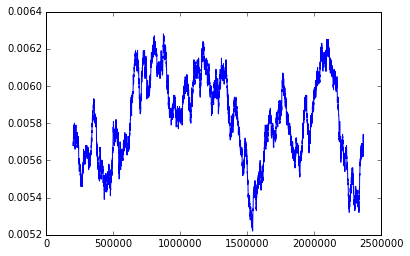

In [139]:
plt.plot(tmp)

In [103]:
combined_labels = pd.merge(all_labels, start_time, how='left', left_index=True, right_index=True)

In [149]:
sorted_combined.head()

,Response,L0_S0_D1,start_time_diff
Id,,,
746919,0,1.10,-1710.07
582229,0,3.90,-1709.76
2120607,0,1.02,-1709.47
1395613,0,0.66,-1709.24
1277674,0,1.57,-1709.08


In [169]:
sorted_combined = combined_labels.sort('start_time_diff')
clean_df = sorted_combined.reset_index()
tmp = pd.rolling_mean(clean_df['Response'], 50000)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50000,center=False).mean()
  app.launch_new_instance()


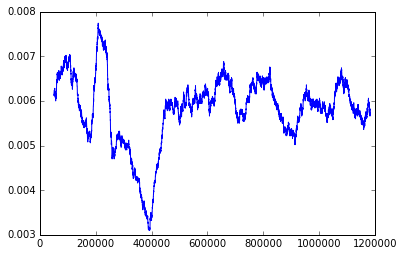

In [170]:
plt.plot(tmp)

In [104]:
sorted_combined = combined_labels.sort('start_time_diff')

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [93]:
#all_labels.iloc[0:100, [True]]

In [80]:
all_labels.columns.isin(['Response'])

array([ True], dtype=bool)

In [125]:
bin_num = 200
def getAvg_depVar_mean(df, dep_var_name, bin_num):
    bin_range = []
    for i in range(bin_num):
        bin_range.append(int(1.*df.shape[0]/bin_num*i))
    bin_range.append(df.shape[0])
    avg_dep_var = []
    for i in range(bin_num):
        mean_value = df.iloc[bin_range[i]:bin_range[i+1], df.columns.isin([dep_var_name])].mean()
        #print mean_value
        avg_dep_var.append(mean_value)
        
    return avg_dep_var

In [130]:
#aa= getAvg_depVar_mean(sorted_combined, 'Response', bin_num)
aa= getAvg_depVar_mean(all_labels, 'Response', bin_num)

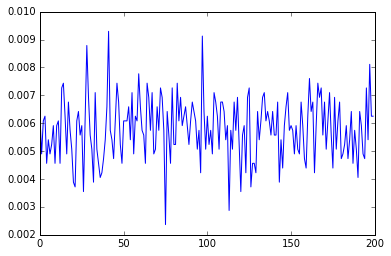

In [131]:
plt.plot(aa)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=1000,center=False).mean()
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76fb157390>]], dtype=object)

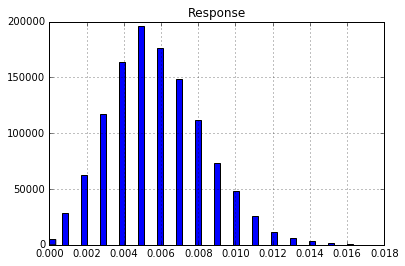

In [21]:
pd.rolling_mean(all_labels, 1000).hist(bins=50)

In [16]:
pos_index = all_labels.loc[all_labels['Response']==1, :].index
neg_index = all_labels.loc[all_labels['Response']==0, :].index

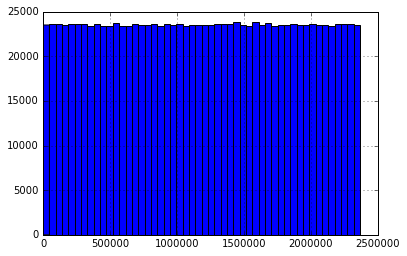

In [17]:
pd.Series(neg_index).hist(bins=50)

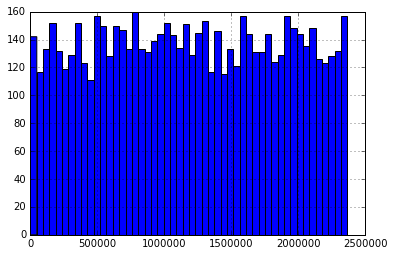

In [15]:
pd.Series(pos_index).hist(bins=50)